# **Table of contents**<a id='toc0_'></a>    
1. [Data Preparation](#toc1_)    
2. [Spotify Test](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

<Axes: xlabel='count', ylabel='mood'>

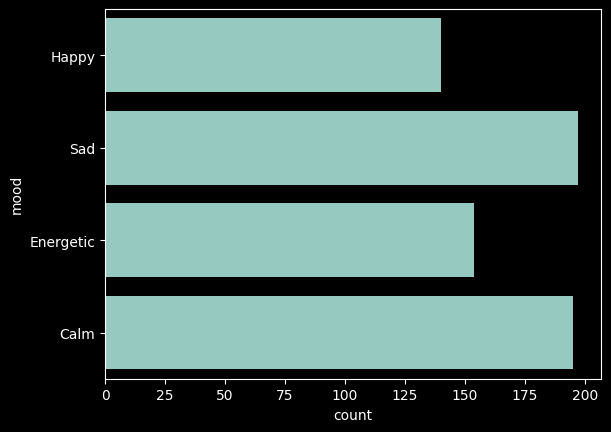

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # Seaborn for data visualization
import joblib

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
# Load the data
df = pd.read_csv('data_moods.csv')
df['popularity'] = 0.
# Checking null value in dataset
df.isnull().sum()
# Visualize number of data point for each class
sns.countplot(df['mood'])

# 1. <a id='toc1_'></a>[Data Preparation](#toc0_)

In [5]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
# Feature engineering
X = df.loc[:, 'popularity':'time_signature']
X['length'] = X['length']/max(X['length'])

# Mapping class label to respected integer
y = df['mood'].map({'Happy': 0, 'Sad': 1, 'Energetic': 2, 'Calm':3})
target_names = ['Happy', 'Sad', 'Energetic', 'Calm']
# Splitting training data and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
models = []
# models.append(('Random Forest Classifier',RandomForestClassifier()))
models.append(('Gradient Boosting Classifier',GradientBoostingClassifier()))
# models.append(('XGB Classifier', XGBClassifier()))
# models.append(('Decision Tree Classifier', DecisionTreeClassifier()))
# models.append(('LGBM Classifier', LGBMClassifier()))
# models.append(('Support Vector Classifier', SVC()))
# models.append(('KNN Classifier', KNeighborsClassifier()))

for name, model in models:
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    accuracy = accuracy_score(predictions, y_test)

    print('Accuracy for {} : {:3.3f}\nClassification Report for {} : \n{}'.format(name, accuracy_score(predictions, y_test), name, classification_report(predictions, y_test, target_names=target_names)))
    joblib.dump(model, '{}.bin'.format(name))

Accuracy for Gradient Boosting Classifier : 0.855
Classification Report for Gradient Boosting Classifier : 
              precision    recall  f1-score   support

       Happy       0.70      0.62      0.65        26
         Sad       0.93      0.93      0.93        42
   Energetic       0.76      0.82      0.79        34
        Calm       0.97      0.97      0.97        36

    accuracy                           0.86       138
   macro avg       0.84      0.83      0.84       138
weighted avg       0.85      0.86      0.85       138



# 2. <a id='toc2_'></a>[Spotify Test](#toc0_)

In [7]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import os
from dotenv import load_dotenv

# Load variables from .env
load_dotenv()

CLIENT_ID = os.getenv('SPOTIPY_CLIENT_ID')
CLIENT_SECRET = os.getenv('SPOTIPY_CLIENT_SECRET')

# Authenticate
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
))

# Search for the track
results = sp.search(q="Can't stop the feeling!", limit=1, type="track")
tracks = results['tracks']['items']

if tracks:
    track_id = tracks[0]['id']
    print(f"Track ID for 'Shared Trauma pierce the veil': {track_id}")
else:
    print("No results found for the given query.")

data = sp.audio_features(track_id)

spotify_data = pd.DataFrame(data)
spotify_data = spotify_data[['duration_ms', 'danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 'valence', 'loudness', 'speechiness', 'tempo', 'key', 'time_signature']]

# Rename 'duration_ms' to 'length'
spotify_data.rename(columns={'duration_ms': 'length'}, inplace=True)
spotify_data['popularity'] = 1
# Reorder columns
ordered_columns = ['popularity', 'length', 'danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 'valence', 'loudness', 'speechiness', 'tempo', 'key', 'time_signature']
spotify_data = spotify_data[ordered_columns]
spotify_data

# Predict
model_name = "Gradient_Boosting_Classifier"
loaded_model = joblib.load('assets/{}.bin'.format(model_name))
result = loaded_model.predict(spotify_data)
result

Track ID for 'Shared Trauma pierce the veil': 1WkMMavIMc4JZ8cfMmxHkI


array([0])

In [9]:
[0]

0